This notebook visualizes the radar data from the CARRADA dataset.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

In [11]:
ADC_DIR = 'ADC'
data_path = 'data/Carrada_tiny'
seq_name = '2020-02-28-13-09-58'
instances = ['001114', '001115']
frame_name = '000117'

seq_path = os.path.join(data_path, seq_name)
rd_path = os.path.join(seq_path, 'range_doppler_numpy', frame_name + '.npy')
ra_path = os.path.join(seq_path, 'range_angle_numpy', frame_name + '.npy')
img_path = os.path.join(seq_path, 'camera_images', frame_name + '.jpg')
rad_path = os.path.join(data_path, ADC_DIR, seq_name, 'RAD_numpy', frame_name + '.npy')
annotations_path = os.path.join(data_path, seq_name, 'annotations_frame_oriented.json')

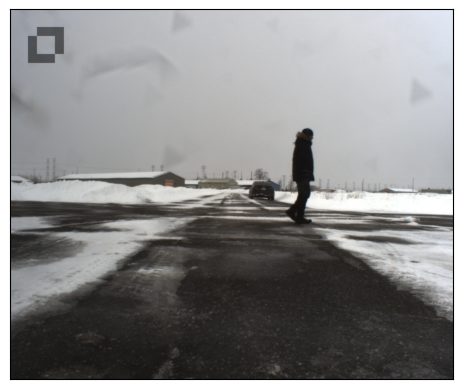

In [12]:
# Load image and show it
img = plt.imread(img_path)
# remove x and y ticks
plt.xticks([])
plt.yticks([])
plt.imshow(img)

#### Recover Range-Angle map and Range-Doppler map from RAD (Range-Angle-Doppler) data.

In [13]:
# Load RAD data (.npy)
rad_matrix = np.load(rad_path)
print('RAD matrix shape:', rad_matrix.shape, rad_matrix.dtype)

RAD matrix shape: (256, 256, 64) float32


In [14]:
# Convert RAD matrix to Range-Angle matrix
def to_ra(data):
    ra_data = np.max(data, axis=2)
    # ra_data = 10 * np.log10(ra_data + 1e-10)

    return ra_data

RA matrix shape: (256, 256)


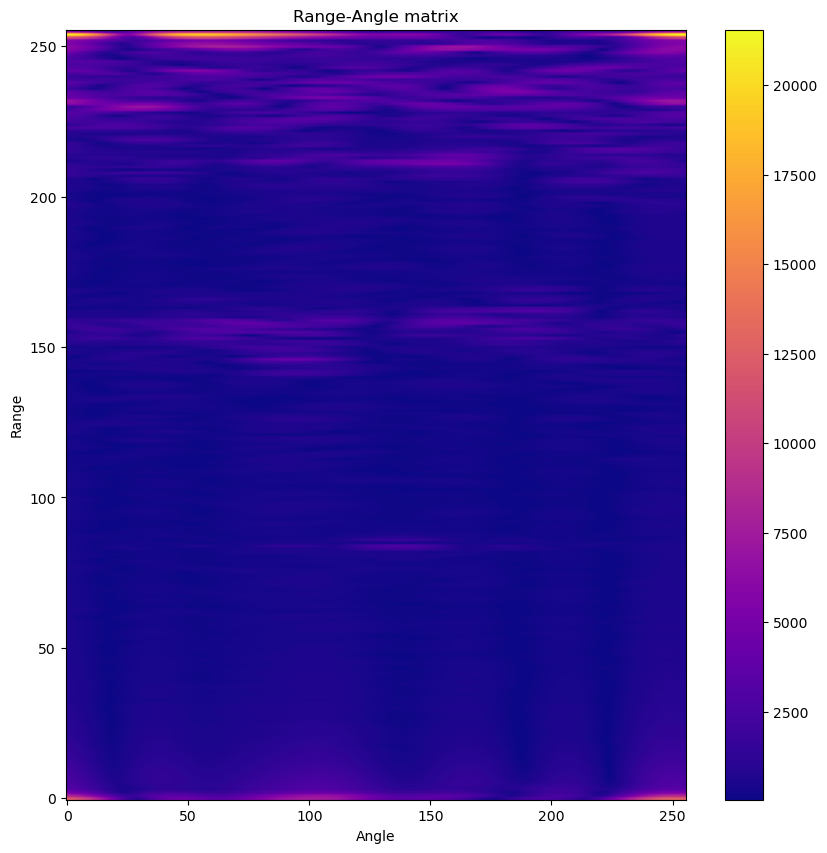

In [21]:
ra_matrix = to_ra(rad_matrix)
print('RA matrix shape:', ra_matrix.shape)

# Visualize Range-Angle matrix
plt.figure(figsize=(10, 10))
plt.imshow(ra_matrix, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar()
plt.title('Range-Angle matrix')
plt.xlabel('Angle')
plt.ylabel('Range')
plt.show()

In [16]:
# # Convert RAD matrix to Range-Doppler matrix
# def to_rd(data):
#     rd_data = np.rot90(data, 2)
#     rd_data = np.max(data, axis=1)
#     rd_data = 10 * np.log10(rd_data + 1e-10)

#     return rd_data

In [17]:
# Convert RAD matrix to Range-Doppler matrix
def to_rd(data):
    processing = np.rot90(data, 2)
    # Undo the FFT on the angle dim (Rx/Tx pairs)
    processing = np.fft.ifftshift(processing, axes=1)
    processing = np.fft.ifft(processing, axis=1)
    processing = pow(np.abs(processing), 2)
    processing = np.sum(processing, axis=1)
    rd_data = 10*np.log10(processing + 1)

    return rd_data

### 为什么从RAD数据中提取RD图需要ifft变换？
是否需要进行IFFT变换以提取RD图取决于雷达系统的配置以及所需的信息精度。在单天线系统或数据预处理足够的情况下，可以直接从RAD立方体提取RD图，而无需IFFT。但在多天线系统中，进行IFFT可以提高数据的信息利用率和精确度，尤其是在需要准确提取目标方位信息时。这是为了确保可以从多角度获得的数据中获得最全面的信息解读。

RD matrix shape: (256, 64)


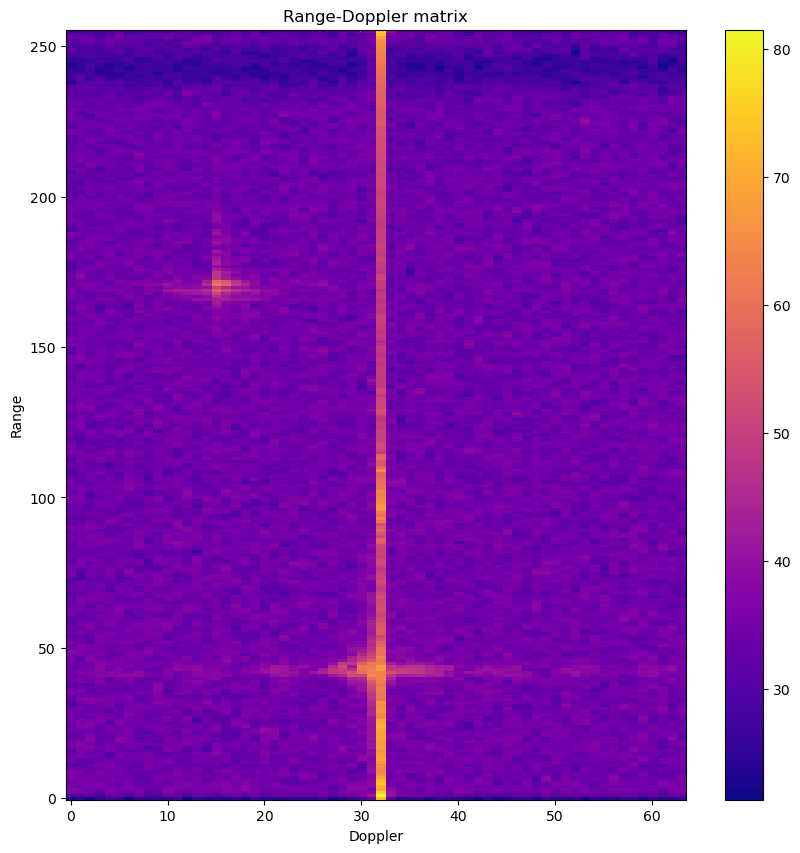

In [20]:
rd_matrix = to_rd(rad_matrix)
print('RD matrix shape:', rd_matrix.shape)

# Visualize Range-Doppler matrix
plt.figure(figsize=(10, 10))
plt.imshow(rd_matrix, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar()
plt.title('Range-Doppler matrix')
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.show()

#### Load the Range-Angle and Range-Doppler data directly from the dataset.

In [19]:
ra_matrix = np.load(ra_path)
rd_matrix = np.load(rd_path)